# Exploratary Data Analysis 2

In [16]:
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sbs
import geopandas as gpd
import folium 

In [17]:
from pyspark.sql import SparkSession

# Create a spark session with increased memory allocation
spark = (
    SparkSession.builder.appName("ADS Project1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "8g")  # Set the driver memory to 8GB
    .config("spark.executor.memory", "8g")  # Set the executor memory to 8GB
    .getOrCreate()
)

## Datasets 

### Daily demand

In [18]:
# Load the Parquet file into a Pandas DataFrame
clean_df = pd.read_parquet("../data/curated/merged_data/second_cleaned.parquet/")

In [19]:
# check schema
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              949 non-null    object 
 1   PUBorough         949 non-null    object 
 2   daily_trip_count  949 non-null    int64  
 3   Number of Events  949 non-null    int64  
 4   avg_CIG           949 non-null    float64
 5   avg_WND           949 non-null    float64
 6   avg_VIS           949 non-null    float64
 7   avg_TMP           949 non-null    float64
 8   avg_DEW           949 non-null    float64
 9   avg_SLP           949 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 74.3+ KB


### Daily Trips by borough

     borough  total_daily_trips
0      Bronx              25368
1   Brooklyn              89575
2        EWR                221
3  Manhattan           14642364
4     Queens            1722625


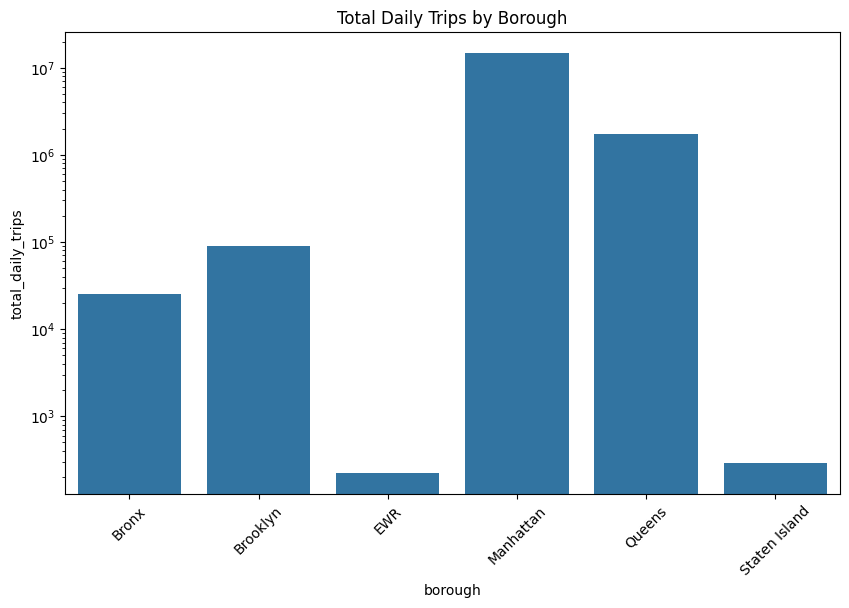

In [20]:
# Aggregate the number of daily trips by PUBorough
agg_data_daily = clean_df.groupby('PUBorough').agg({
    'daily_trip_count': 'sum'
}).reset_index()

# Rename the columns to match the expected output
agg_data_daily.rename(columns={'PUBorough': 'borough', 'daily_trip_count': 'total_daily_trips'}, inplace=True)

# Display the first 5 rows of the aggregated data
print(agg_data_daily.head())

# Create a bar chart with a log scale
fig, ax = plt.subplots(figsize=(10, 6))

# Create the bar plot using Seaborn
sbs.barplot(x='borough', y='total_daily_trips', data=agg_data_daily, ax=ax)

# Set the y-axis to a logarithmic scale
ax.set_yscale('log')

# Set the title of the plot
ax.set_title('Total Daily Trips by Borough')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()


In [21]:
# save the plot
fig.savefig("../plots/total_daily_trips_by_borough.png")

### Pickups for each day of week

In [22]:
# check schema
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 949 entries, 0 to 948
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              949 non-null    object 
 1   PUBorough         949 non-null    object 
 2   daily_trip_count  949 non-null    int64  
 3   Number of Events  949 non-null    int64  
 4   avg_CIG           949 non-null    float64
 5   avg_WND           949 non-null    float64
 6   avg_VIS           949 non-null    float64
 7   avg_TMP           949 non-null    float64
 8   avg_DEW           949 non-null    float64
 9   avg_SLP           949 non-null    float64
dtypes: float64(6), int64(2), object(2)
memory usage: 74.3+ KB


In [24]:
# day of the week
clean_df['pickup_day'] = pd.to_datetime(clean_df['date']).dt.day_name()

In [25]:
# Plot number of pick ups per day of the week
# Group by 'Day of Week' and count the number of trips
trips_per_day_df = clean_df.groupby('pickup_day').agg({'daily_trip_count': 'mean'}).reset_index()

In [26]:
# define the order of the days of the week
days_order = [
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
]

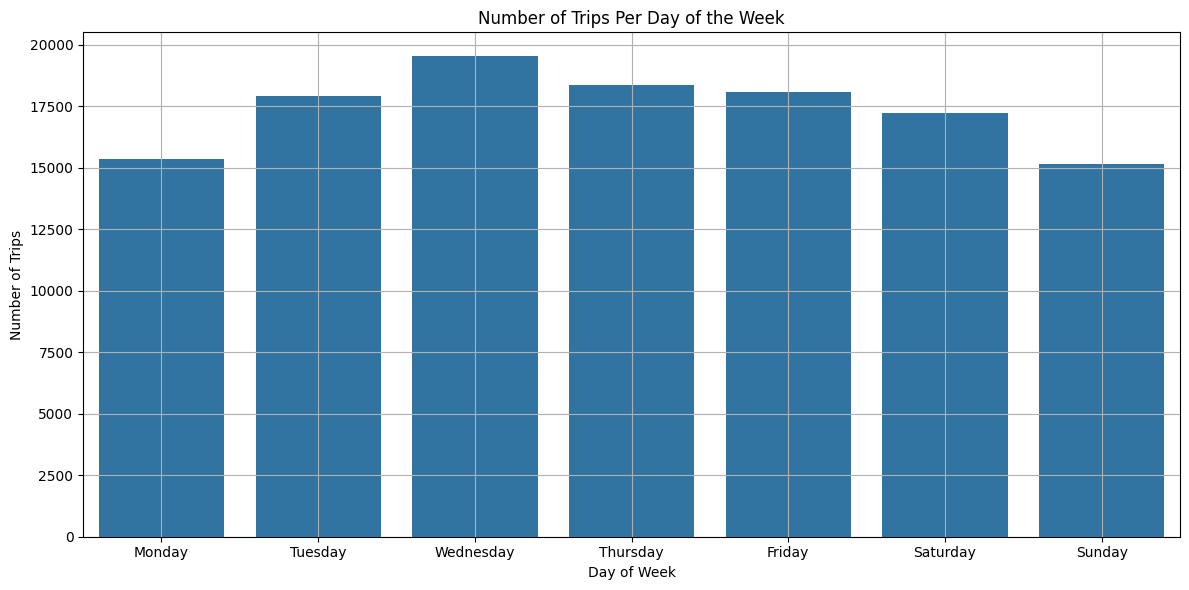

In [27]:
# Plot the number of trips per day of the week
plt.figure(figsize=(12, 6))
sbs.barplot(x='pickup_day', y='daily_trip_count', data=trips_per_day_df, order=days_order)
plt.title('Number of Trips Per Day of the Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.tight_layout()
# save the plot
plt.savefig('../plots/number_of_trips_per_day_of_week.png')

In [28]:
# how tmperature affect the number of trips 
# Group by 'avg_TMP' and count the number of trips
trips_per_temp_df = clean_df.groupby('avg_TMP').agg({'daily_trip_count': 'sum'}).reset_index()

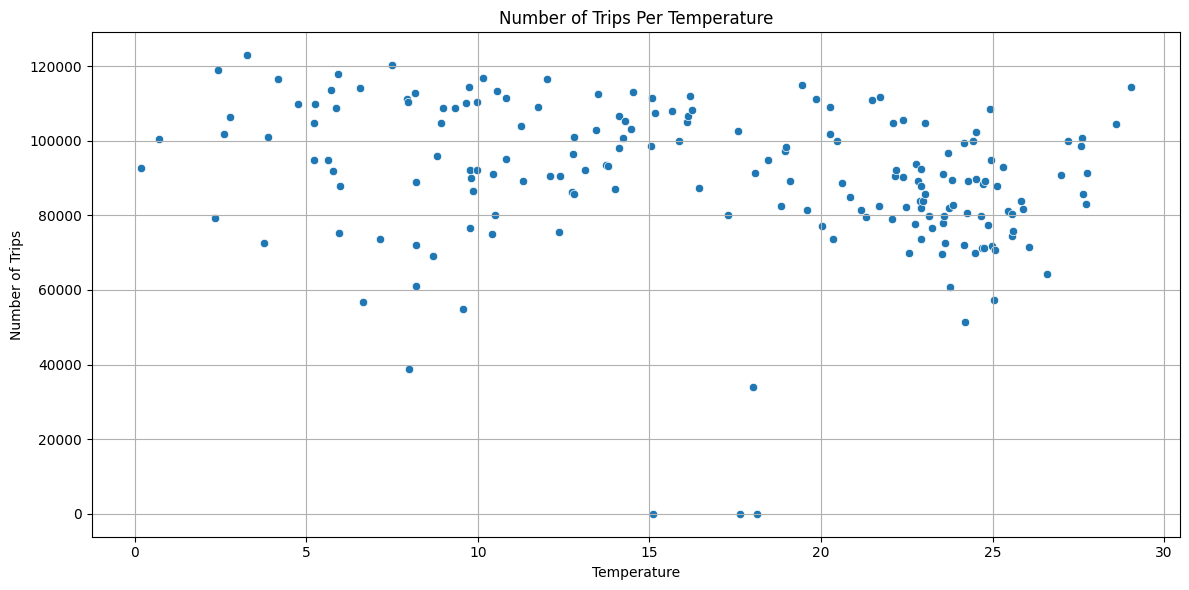

In [29]:
# Plot the number of trips per temperature
plt.figure(figsize=(12, 6))
sbs.scatterplot(x='avg_TMP', y='daily_trip_count', data=trips_per_temp_df)
plt.title('Number of Trips Per Temperature')
plt.xlabel('Temperature')
plt.ylabel('Number of Trips')
plt.grid(True)
plt.tight_layout()